# Discussion
## Error Analisys


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from joblib import dump, load
import tensorflow as tf
import seaborn as sns
import math

import header as h

import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator
from matplotlib.backends.backend_pdf import PdfPages
from scipy import optimize
plt.style.use('mystyle.mplstyle')

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', \
          u'#bcbd22', u'#17becf']

solar_like_path = '../data/solar-like.csv'
LAMOST_Gaia_APOGEE_path = '../data/dataset/LGA/LAMOST_Gaia_APOGEE.csv'
LAMOST_Gaia_APOGEE_parampath = '../data/dataset/LGA/LAMOST_Gaia_APOGEE_param.csv'
LAMOST_Gaia_path = '../data/dataset/LG/LAMOST_Gaia.csv'
LAMOST_Gaia_parampath = '../data/dataset/LG/LAMOST_Gaia_param.csv'

In [2]:
# .csv 为样本总表（不包含输入）， _param.csv仅包含输入输出，两表obsid顺序相同
LAMOST_Gaia_dir = '/Volumes/Vega/data/dataset/LAMOST-Gaia/'
LAMOST_Gaia_APOGEE_dir = '/Volumes/Vega/data/dataset/LAMOST-Gaia-APOGEE/'

scaler_filepath = 'std_scaler_cutdata.bin'
model_filepath = 'model_32_cutdata'
scaler_filepath = 'std_scaler.bin'
model_filepath = 'model_32'
history_filepath = ['history_32.csv','history_34.csv','history_44.csv','history_45.csv']

data = 'LAMOST_Gaia_APOGEE'

historypath = []
if data == 'LAMOST_Gaia':
    datapath = LAMOST_Gaia_parampath
    dataallpath = LAMOST_Gaia_path
    scalerpath = LAMOST_Gaia_dir + scaler_filepath
    modelpath = LAMOST_Gaia_dir + model_filepath
    for i in range(len(history_filepath)):
        historypath.append(LAMOST_Gaia_dir + history_filepath[i])
elif data == 'LAMOST_Gaia_APOGEE':
    datapath = LAMOST_Gaia_APOGEE_parampath
    dataallpath = LAMOST_Gaia_APOGEE_path
    scalerpath = LAMOST_Gaia_APOGEE_dir + scaler_filepath
    modelpath = LAMOST_Gaia_APOGEE_dir + model_filepath
    for i in range(len(history_filepath)):
        historypath.append(LAMOST_Gaia_APOGEE_dir + history_filepath[i])
        
dataall = pd.read_csv(dataallpath)
dataset = pd.read_csv(datapath)
labels = ['teff','logg','feh','mg_geo','bp_rp_0']
X = dataset.iloc[:,7:4882]
y = dataset.loc[:,labels]
obsid = dataset.loc[:,'obsid']

# 以 8:2 的比例划分训练集和测试集，obsid_train 为 y_train 顺序对应的 obsid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
obsid_train, obsid_test = train_test_split(obsid, test_size = 0.2, random_state = 42, shuffle = True)

# 读取标准化参数
scaler = load(scalerpath)
# 对训练集和测试集标准化
# y_test.values[:] = scaler.transform(y_test)
y_test = scaler.transform(y_test)
# y_train.values[:] = scaler.transform(y_train)

# size for the sets
print('size of X_train:', X_train.shape,'size of y_train:', y_train.shape)
print('size of X_test:', X_test.shape,'size of y_test:', y_test.shape)
# Reshape train and test data to (n_samples, 187, 1), where each sample is of size (187, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = np.array(y_train).reshape(y_train.shape[0], y_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1])
print("reshape X_train: ", X_train.shape,"reshape y_train: ", y_train.shape)
print("reshape X_test: ", X_test.shape,"reshape y_test: ", y_test.shape)

# 读取模型
model = tf.keras.models.load_model(modelpath)

prediction = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)))
prediction.columns = ['pre_teff','pre_logg','pre_feh','pre_mg_geo','pre_bp_rp_0']

obsid_test = obsid_test.reset_index(drop=True)
prediction['obsid'] = obsid_test

test = prediction.merge(dataall,how='left',on='obsid')

/Users/sara/miniconda3/envs/specparam/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


size of X_train: (14858, 4875) size of y_train: (14858, 5)
size of X_test: (3715, 4875) size of y_test: (3715, 5)
reshape X_train:  (14858, 4875, 1) reshape y_train:  (14858, 5)
reshape X_test:  (3715, 4875, 1) reshape y_test:  (3715, 5)
  3/117 [..............................] - ETA: 3s 

2024-03-13 14:45:27.547973: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


117/117 [==============================] - 4s 32ms/step


In [3]:
if data == 'LAMOST_Gaia_APOGEE':
    ori_teff = test['TEFF_1']
    ori_logg = test['LOGG_1']
    ori_feh = test['FE_H']
    x_label = ['$T_{eff}$'+' $_{APOGEE}$','log $g_{APOGEE}$','[Fe/H]$_{APOGEE}$','$M_{Ggeo}$','$(G_{BP}-G_{RP})_{0}$','$d_{geo}$']
    y_label = ['$T_{eff}$'+' $_{CNN1}$','log $g_{CNN1}$','[Fe/H]$_{CNN1}$','$M_{Ggeo}$'+' $_{CNN1}$','$(G_{BP}-G_{RP})_{0}$'+' $_{CNN1}$','$d_{geo}$'+' $_{CNN1}$']
elif data == 'LAMOST_Gaia':
    ori_teff = test['teff_2']
    ori_logg = test['logg_2']
    ori_feh = test['feh']
    x_label = ['$T_{eff}$'+' $_{LAMOST}$','log $g_{LAMOST}$','[Fe/H]$_{LAMOST}$','$M_{Ggeo}$','$(G_{BP}-G_{RP})_{0}$','$d_{geo}$']
    y_label = ['$T_{eff}$'+' $_{CNN2}$','log $g_{CNN2}$','[Fe/H]$_{CNN2}$','$M_{Ggeo}$'+' $_{CNN2}$','$(G_{BP}-G_{RP})_{0}$'+' $_{CNN2}$','$d_{geo}$'+' $_{CNN2}$']
ori_mg = test['mg_geo']
ori_bprp0 = test['bp_rp_0']

pre_labels = ['pre_teff','pre_logg','pre_feh','pre_mg_geo','pre_bp_rp_0']
pre_teff = test[pre_labels[0]]
pre_logg = test[pre_labels[1]]
pre_feh = test[pre_labels[2]]
pre_mg = test[pre_labels[3]]
pre_bprp0 = test[pre_labels[4]]

resid_teff = ori_teff - pre_teff
resid_logg = ori_logg - pre_logg
resid_feh = ori_feh - pre_feh
resid_mg = ori_mg - pre_mg
resid_bprp0 = ori_bprp0 - pre_bprp0

mu_teff, sigma_teff = np.mean(ori_teff - pre_teff), np.std(ori_teff - pre_teff)
mu_logg, sigma_logg = np.mean(ori_logg - pre_logg), np.std(ori_logg - pre_logg)
mu_feh, sigma_feh = np.mean(ori_feh - pre_feh), np.std(ori_feh - pre_feh)
mu_mg, sigma_mg = np.mean(ori_mg - pre_mg), np.std(ori_mg - pre_mg)
mu_bprp0, sigma_bprp0 = np.mean(ori_bprp0 - pre_bprp0), np.std(ori_bprp0 - pre_bprp0)

lim_teff = (min(min(ori_teff),min(pre_teff))-20, max(max(ori_teff),max(pre_teff))+20)
lim_logg = (min(min(ori_logg),min(pre_logg)), max(max(ori_logg),max(pre_logg)))
lim_feh = (min(min(ori_feh),min(pre_feh)), max(max(ori_feh),max(pre_feh)))
lim_mg = (min(min(ori_mg),min(pre_mg)), max(max(ori_mg),max(pre_mg)))
lim_bprp0 = (min(min(ori_bprp0),min(pre_bprp0)), max(max(ori_bprp0),max(pre_bprp0)))

print('sigma_mg : ',sigma_mg)

sigma_mg :  0.25464918408761095


In [4]:
from scipy.optimize import minimize_scalar
# 从预测的绝对星等 M 计算距离 d
# 假设绝对星等M服从正态分布 M～N(mu,sigma)
def p_M(M,mu,sigma):
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(M-mu)**2 / (2*(sigma**2)))
# 根据概率密度传递公式推算得到的 距离的pdf
def p_d(d,m,mu_M,sigma_M,A):
    return np.abs(5/(d*np.log(10))) * p_M(M = m-5*np.log10(d)+5-A,mu = mu_M,sigma = sigma_M)

# 取反的 p_d(d)
def neg_p_d(d, m, mu_M, sigma_M, A):
    return -p_d(d, m, mu_M, sigma_M, A)

m = test['gaia_g_mean_mag']
mu_M = test['pre_mg_geo']
sigma_M = sigma_mg
A = test['azero_gspphot']
print(sigma_M)

# 初始化一个列表，用于存储每组数据的最大值所对应的 d 值
d_max_values = []

# 遍历每组数据
for m_i, mu_M_i, A_i in zip(m, mu_M, A):
    result = minimize_scalar(neg_p_d, args=(m_i, mu_M_i, sigma_M, A_i), bounds=(0, 1e4), method='bounded')
    d_max_values.append(result.x)

# 输出最大值所对应的 d 值
print("最大值所对应的 d 值：", d_max_values)

test['pre_d_med'] = d_max_values
test['direct_d'] = 10 ** ((5-test['azero_gspphot']+test['gaia_g_mean_mag']-test['pre_mg_geo']) / 5)

0.25464918408761095
最大值所对应的 d 值： [173.67101122206705, 425.1350681901629, 467.83942655293214, 267.108515375312, 443.1997452561946, 207.78121876921182, 384.6338055256966, 879.0604179051478, 316.7632369423854, 311.77366388216734, 447.22070236894336, 841.6322851472833, 389.5473717489268, 486.8912325363775, 378.6114938923452, 335.17701001399985, 489.45248781989545, 208.6280322673131, 170.60046731336382, 937.9394147769253, 497.94609500977947, 198.83262695977962, 294.8081117160096, 310.8032617116465, 429.54574950848007, 250.30915035412082, 420.3536342697133, 492.73492363963396, 510.7513820764303, 576.035872695265, 389.1790406909827, 318.3068107765749, 328.1132677895169, 252.99229849447764, 267.25776584292197, 807.9393904831875, 300.73896685339275, 307.26382759992566, 277.2720467914183, 695.2368643410196, 384.7551424184433, 334.19465206870876, 383.88159806731767, 211.30837182912816, 443.78809596074103, 551.203510256716, 331.38904149142303, 554.8393801732508, 196.48354018357318, 861.10357364492

In [3]:
# test.to_csv('/Volumes/Vega/data/dataset/LAMOST-Gaia-APOGEE/test_result.csv',index=False)

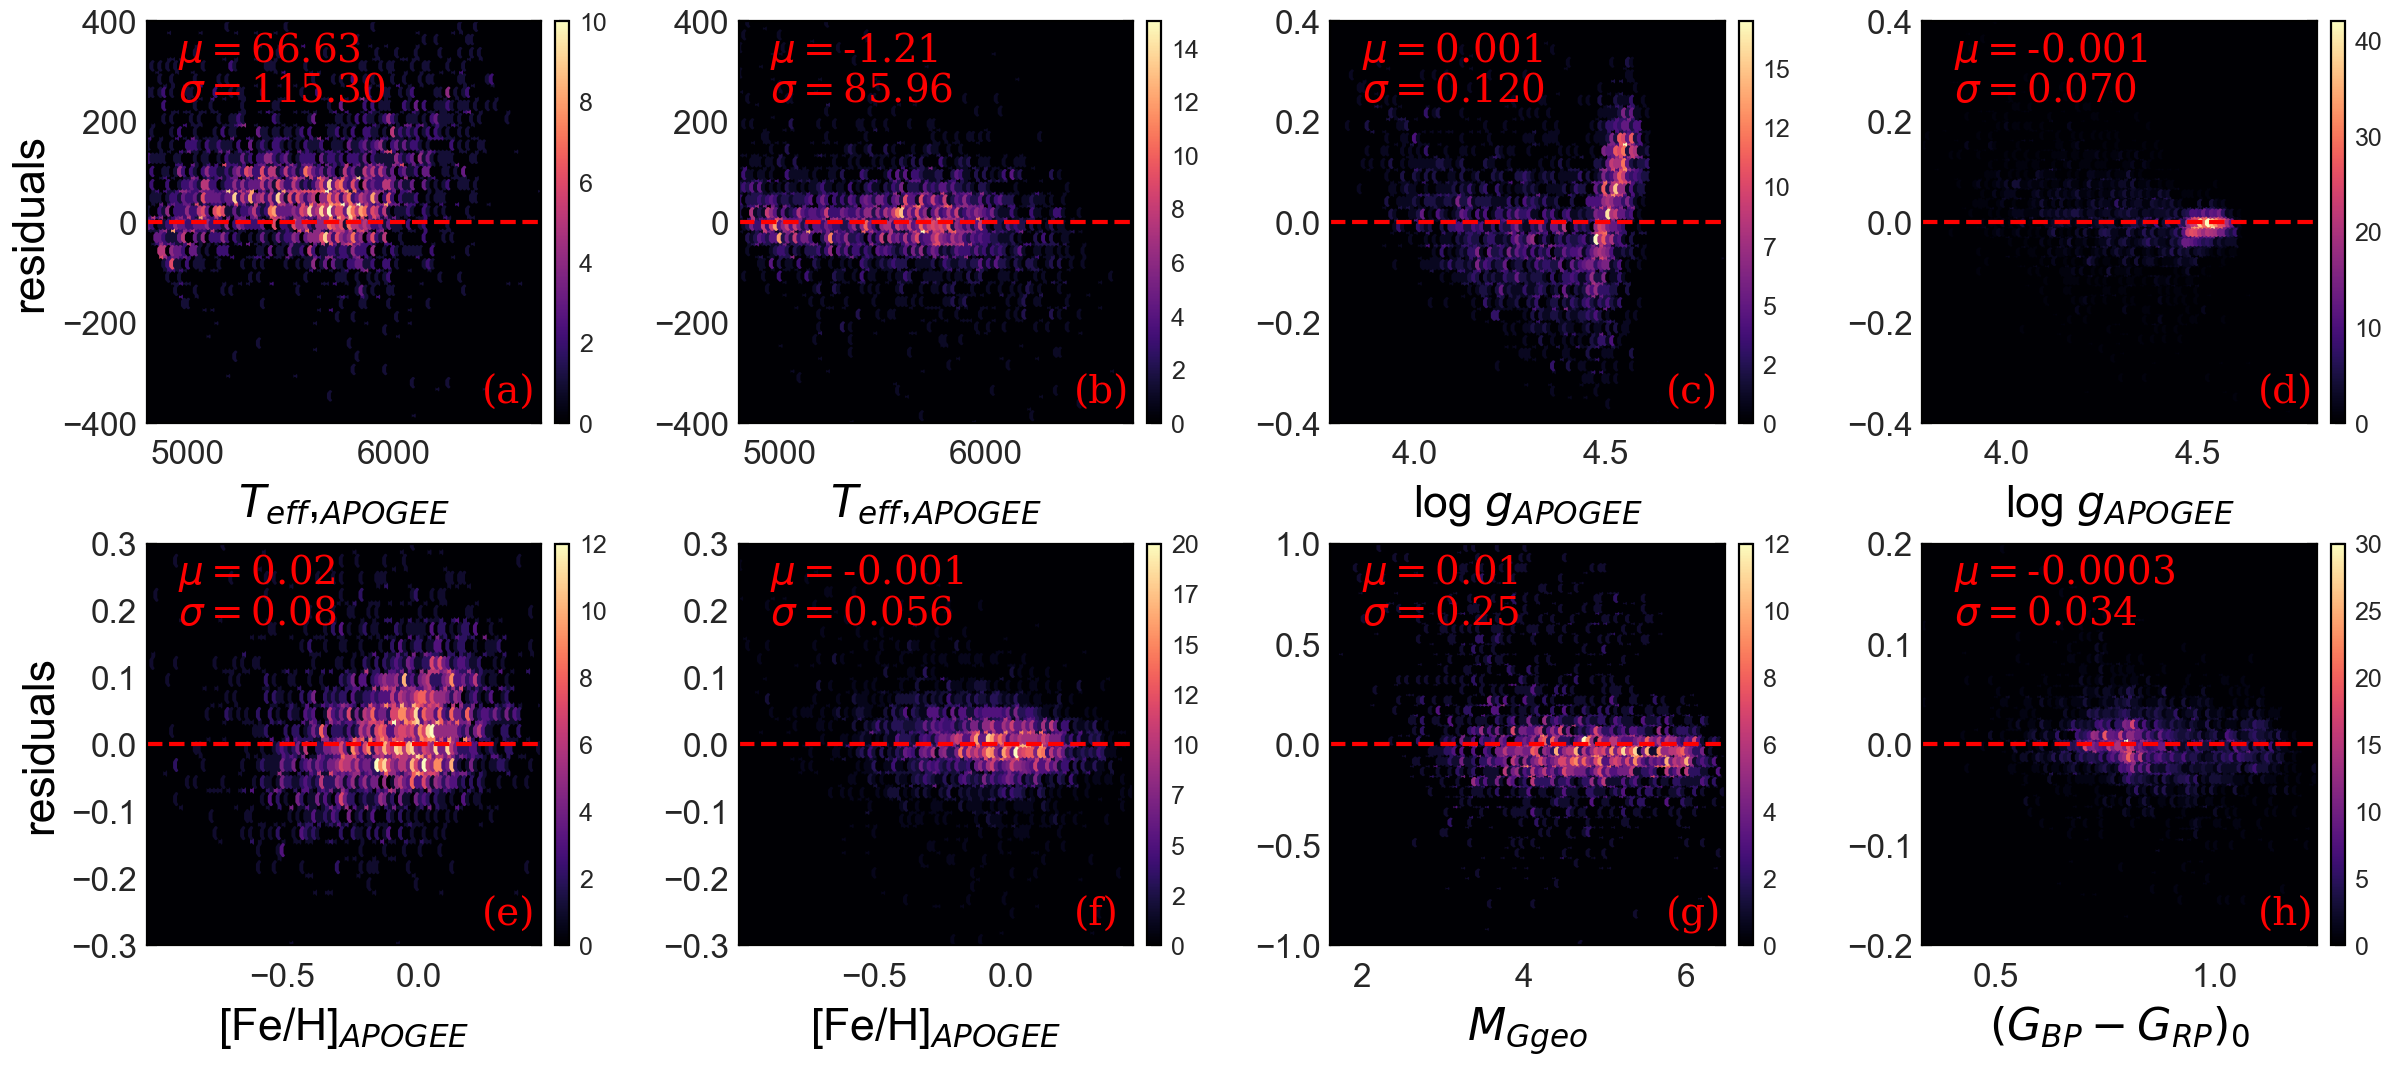

In [11]:
def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)
    return cax

x_label = [
    '$T_{eff}$'+',$_{APOGEE}$', '$T_{eff}$'+',$_{APOGEE}$',
    'log $g_{APOGEE}$', 'log $g_{APOGEE}$', 
    '[Fe/H]$_{APOGEE}$', '[Fe/H]$_{APOGEE}$',
    '$M_{Ggeo}$', '$(G_{BP}-G_{RP})_{0}$'
]
# y_label = [
#     '$T_{eff}$'+',$_{LAMOST}$'+'$-T_{eff}$'+',$_{APOGEE}$', 
#     '$T_{eff}$'+',$_{CNN1}$'+'$-T_{eff}$'+',$_{APOGEE}$',
#     'log $g_{LAMOST}$'+'$-$log $g_{APOGEE}$', 
#     'log $g_{CNN1}$'+'$-$log $g_{APOGEE}$', 
#     '[Fe/H]$_{LAMOST}$'+'$-$[Fe/H]$_{APOGEE}$',
#     '[Fe/H]$_{CNN1}$'+'$-$[Fe/H]$_{APOGEE}$',
#     '$M_{Ggeo}$'+' $_{CNN1}$'+'$-M_{Ggeo}$', 
#     '$(G_{BP}-G_{RP})_{0}$'+' $_{CNN1}$'+'$-(G_{BP}-G_{RP})_{0}$'
# ]y_label = 'residuals'
fig = plt.figure(figsize=(14,6),dpi=200)
gs = GridSpec(2, 4, figure=fig, wspace=0.5, hspace=0.3)
fontdict = {'size':14, 'color':'r', 'family':'serif'}
ylim = [
    (-400,400),(-400,400), (-0.4,0.4),(-0.4,0.4),
    (-0.3,0.3),(-0.3,0.3), (-1,1), (-0.2,0.2)
    
]
def subplot(gsx,gsy,datax,datay,labelnum,ylim,fnum):
    xlim=(min(datax), max(datax))
    datamu = np.mean(datay)
    datasigma = np.std(datay)
    ax = fig.add_subplot(gs[gsx,gsy])
    hb = ax.hexbin(datax,datay,gridsize=100,cmap='magma')#mincnt=1,
    # 设置的colorbar
    # 自定义刻度标签格式的函数
    def format_func(value, tick_number):
        return f'{int(value)}'
    cax = add_right_cax(ax, pad=0.005, width=0.005)
    cb = fig.colorbar(hb, cax=cax)
    # cb.ax.set_title('Count',fontsize=10)
    cb.ax.tick_params(labelsize=9)
    cb.ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    xmin,xmax=xlim
    ax.hlines(0, xmin, xmax, ls='--',colors='r')
    ax.set_xlabel(x_label[labelnum])
    # ax.set_ylabel(y_label[labelnum])
    if labelnum ==0 or labelnum == 4:
        ax.set_ylabel(y_label)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if fnum == 2: # 保留两位小数
        ax.text(0.85, 0.05, f'({chr(97+gsx*4+gsy)})', transform=ax.transAxes,fontdict=fontdict)
        ax.text(0.08,0.9,'$\mu=$'+'%.2f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
        ax.text(0.08,0.8,'$\sigma=$'+'%.2f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)
    elif fnum == 3: # 保留三位小数
        if labelnum == 7:
            ax.text(0.85, 0.05, f'({chr(97+gsx*4+gsy)})', transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.9,'$\mu=$'+'%.4f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.8,'$\sigma=$'+'%.3f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)    
        else:
            ax.text(0.85, 0.05, f'({chr(97+gsx*4+gsy)})', transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.9,'$\mu=$'+'%.3f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.8,'$\sigma=$'+'%.3f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)           
    return 

test = pd.read_csv('/Volumes/Vega/data/dataset/LAMOST-Gaia-APOGEE/test_result.csv')
subplot(gsx=0, gsy=0, datax=test['TEFF_1'], datay=test['teff_2']-test['TEFF_1'],   labelnum=0, ylim=ylim[0], fnum=2)
subplot(gsx=0, gsy=1, datax=test['TEFF_1'], datay=test['pre_teff']-test['TEFF_1'], labelnum=1, ylim=ylim[1],fnum=2)
subplot(gsx=0, gsy=2, datax=test['LOGG_1'], datay=test['logg_2']-test['LOGG_1'],   labelnum=2, ylim=ylim[2],fnum=3)
subplot(gsx=0, gsy=3, datax=test['LOGG_1'], datay=test['pre_logg']-test['LOGG_1'], labelnum=3, ylim=ylim[3],fnum=3)
subplot(gsx=1, gsy=0, datax=test['FE_H'],   datay=test['feh']-test['FE_H'],        labelnum=4, ylim=ylim[4],fnum=2)
subplot(gsx=1, gsy=1, datax=test['FE_H'],   datay=test['pre_feh']-test['FE_H'],    labelnum=5, ylim=ylim[5],fnum=3)
subplot(gsx=1, gsy=2, datax=test['mg_geo'], datay=test['pre_mg_geo']-test['mg_geo'], labelnum=6, ylim=ylim[6],fnum=2)
subplot(gsx=1, gsy=3, datax=test['bp_rp_0'], datay=test['pre_bp_rp_0']-test['bp_rp_0'], labelnum=7, ylim=ylim[7],fnum=3)
plt.savefig('../figure/error_analisys.pdf')

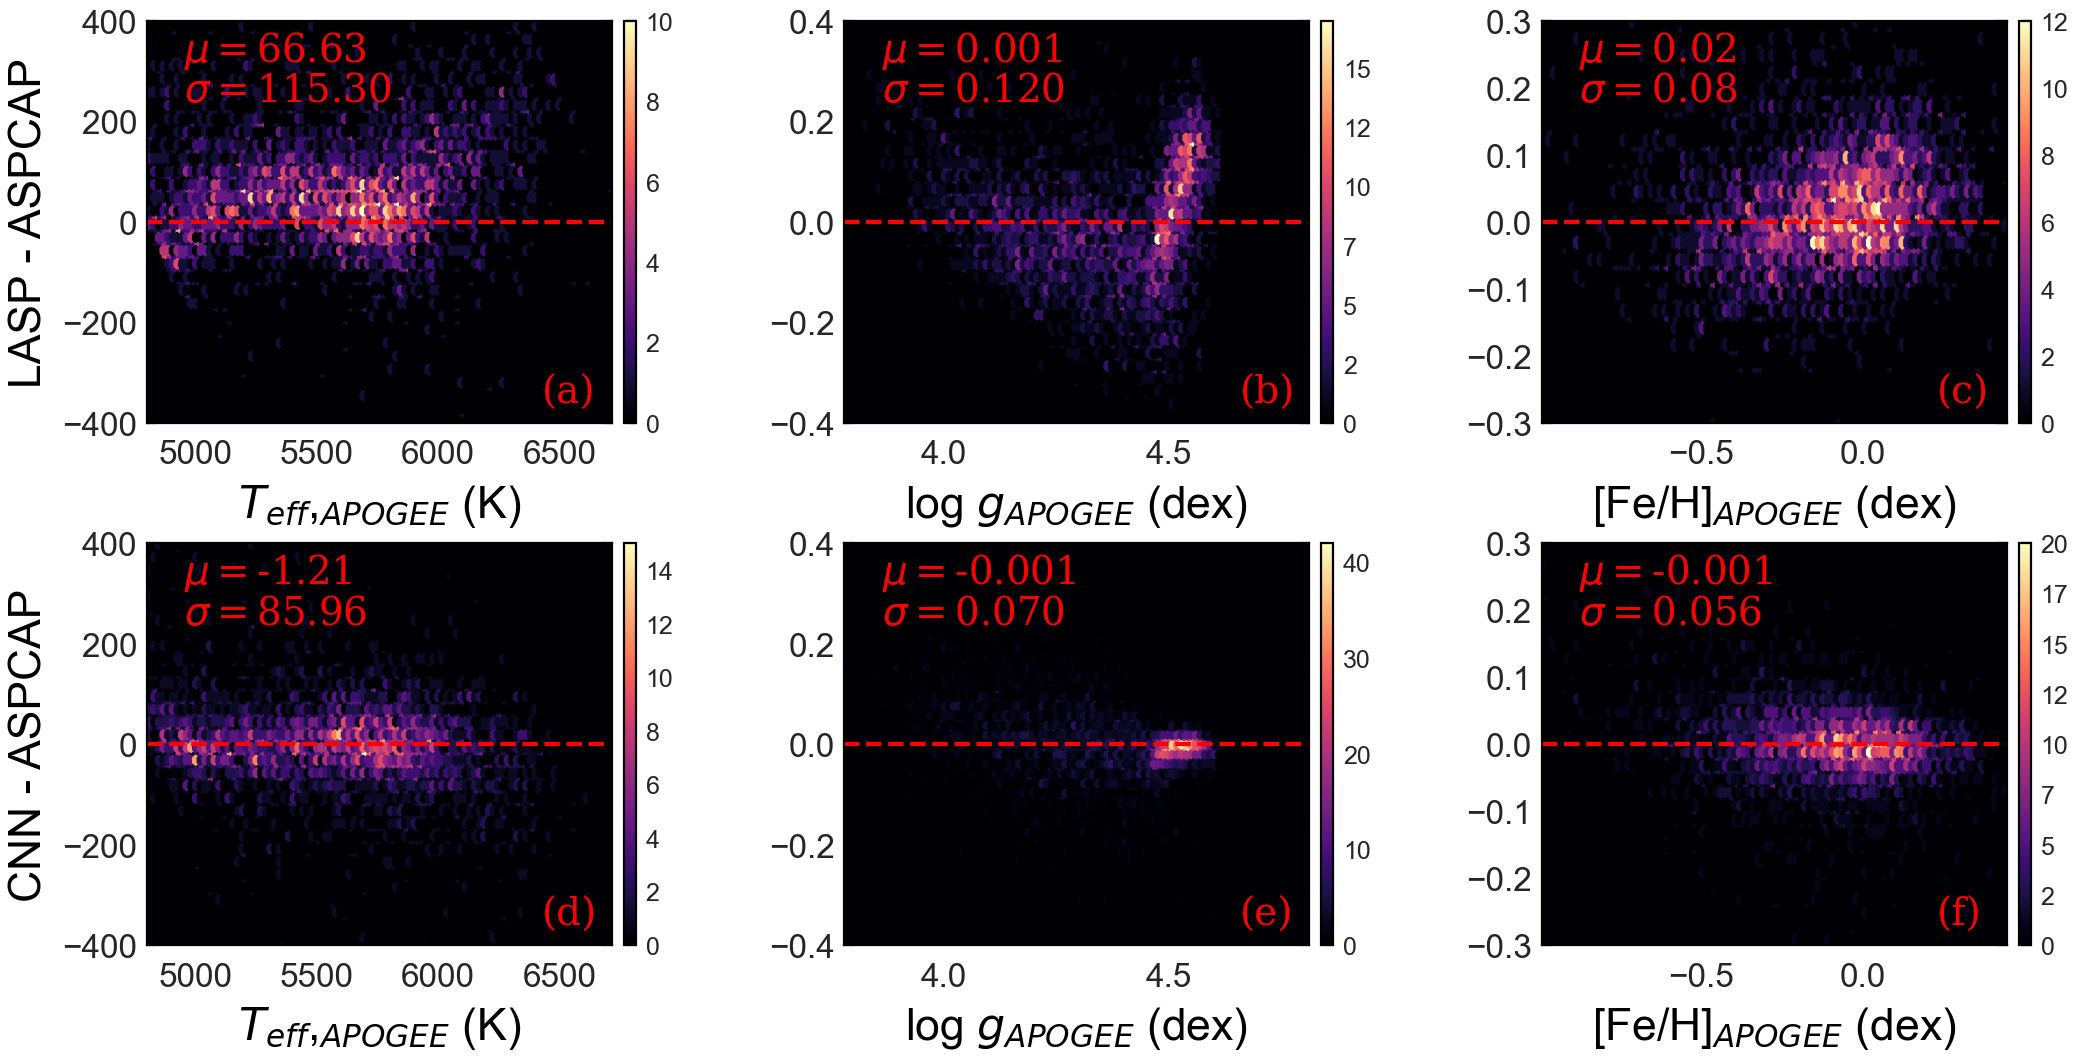

In [5]:
def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)
    return cax

# x_label = [
#     '$T_{eff}$'+',$_{APOGEE}$', '$T_{eff}$'+',$_{APOGEE}$',
#     'log $g_{APOGEE}$', 'log $g_{APOGEE}$', 
#     '[Fe/H]$_{APOGEE}$', '[Fe/H]$_{APOGEE}$',
#     '$M_{Ggeo}$', '$(G_{BP}-G_{RP})_{0}$'
# ]
x_label = [
    '$T_{eff}$'+',$_{APOGEE}$ (K)', '$T_{eff}$'+',$_{APOGEE}$ (K)',
    'log $g_{APOGEE}$ (dex)', 'log $g_{APOGEE}$ (dex)', 
    '[Fe/H]$_{APOGEE}$ (dex)', '[Fe/H]$_{APOGEE}$ (dex)',
    '$M_{Ggeo}$ (mag)', '$(G_{BP}-G_{RP})_{0}$ (mag)'
]
# y_label = [
#     '$T_{eff}$'+',$_{LAMOST}$'+'$-T_{eff}$'+',$_{APOGEE}$', 
#     '$T_{eff}$'+',$_{CNN1}$'+'$-T_{eff}$'+',$_{APOGEE}$',
#     'log $g_{LAMOST}$'+'$-$log $g_{APOGEE}$', 
#     'log $g_{CNN1}$'+'$-$log $g_{APOGEE}$', 
#     '[Fe/H]$_{LAMOST}$'+'$-$[Fe/H]$_{APOGEE}$',
#     '[Fe/H]$_{CNN1}$'+'$-$[Fe/H]$_{APOGEE}$',
#     '$M_{Ggeo}$'+' $_{CNN1}$'+'$-M_{Ggeo}$', 
#     '$(G_{BP}-G_{RP})_{0}$'+' $_{CNN1}$'+'$-(G_{BP}-G_{RP})_{0}$'
# ]
# y_label = 'residuals'
y_label = [
    'LASP - ASPCAP', 'CNN - ASPCAP', '', '',
     '', ''
]
fig = plt.figure(figsize=(12,6),dpi=200)
gs = GridSpec(2, 3, figure=fig, wspace=0.5, hspace=0.3)
fontdict = {'size':14, 'color':'r', 'family':'serif'}
ylim = [
    (-400,400),(-400,400), (-0.4,0.4),(-0.4,0.4),
    (-0.3,0.3),(-0.3,0.3), (-1,1), (-0.2,0.2)
    
]
def subplot(gsx,gsy,datax,datay,labelnum,ylim,fnum):
    xlim=(min(datax), max(datax))
    datamu = np.mean(datay)
    datasigma = np.std(datay)
    ax = fig.add_subplot(gs[gsx,gsy])
    hb = ax.hexbin(datax,datay,gridsize=100,cmap='magma')#mincnt=1,
    # 设置的colorbar
    # 自定义刻度标签格式的函数
    def format_func(value, tick_number):
        return f'{int(value)}'
    cax = add_right_cax(ax, pad=0.005, width=0.005)
    cb = fig.colorbar(hb, cax=cax)
    # cb.ax.set_title('Count',fontsize=10)
    cb.ax.tick_params(labelsize=9)
    cb.ax.yaxis.set_major_formatter(FuncFormatter(format_func))
    xmin,xmax=xlim
    ax.hlines(0, xmin, xmax, ls='--',colors='r')
    ax.set_xlabel(x_label[labelnum])
    ax.set_ylabel(y_label[labelnum])
    # if labelnum ==0 or labelnum == 4:
    #     ax.set_ylabel(y_label[labelnum])
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if fnum == 2: # 保留两位小数
        ax.text(0.85, 0.05, f'({chr(97+gsx*3+gsy)})', transform=ax.transAxes,fontdict=fontdict)
        ax.text(0.08,0.9,'$\mu=$'+'%.2f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
        ax.text(0.08,0.8,'$\sigma=$'+'%.2f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)
    elif fnum == 3: # 保留三位小数
        if labelnum == 7:
            ax.text(0.85, 0.05, f'({chr(97+gsx*3+gsy)})', transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.9,'$\mu=$'+'%.4f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.8,'$\sigma=$'+'%.3f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)    
        else:
            ax.text(0.85, 0.05, f'({chr(97+gsx*3+gsy)})', transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.9,'$\mu=$'+'%.3f'%(datamu),transform=ax.transAxes,fontdict=fontdict)
            ax.text(0.08,0.8,'$\sigma=$'+'%.3f'%(datasigma),transform=ax.transAxes,fontdict=fontdict)           
    return 

test = pd.read_csv('/Volumes/Vega/data/dataset/LAMOST-Gaia-APOGEE/test_result.csv')
subplot(gsx=0, gsy=0, datax=test['TEFF_1'], datay=test['teff_2']-test['TEFF_1'],   labelnum=0, ylim=ylim[0],fnum=2)
subplot(gsx=1, gsy=0, datax=test['TEFF_1'], datay=test['pre_teff']-test['TEFF_1'], labelnum=1, ylim=ylim[1],fnum=2)
subplot(gsx=0, gsy=1, datax=test['LOGG_1'], datay=test['logg_2']-test['LOGG_1'],   labelnum=2, ylim=ylim[2],fnum=3)
subplot(gsx=1, gsy=1, datax=test['LOGG_1'], datay=test['pre_logg']-test['LOGG_1'], labelnum=3, ylim=ylim[3],fnum=3)
subplot(gsx=0, gsy=2, datax=test['FE_H'],   datay=test['feh']-test['FE_H'],        labelnum=4, ylim=ylim[4],fnum=2)
subplot(gsx=1, gsy=2, datax=test['FE_H'],   datay=test['pre_feh']-test['FE_H'],    labelnum=5, ylim=ylim[5],fnum=3)
# subplot(gsx=1, gsy=2, datax=test['mg_geo'], datay=test['pre_mg_geo']-test['mg_geo'], labelnum=6, ylim=ylim[6],fnum=2)
# subplot(gsx=1, gsy=3, datax=test['bp_rp_0'], datay=test['pre_bp_rp_0']-test['bp_rp_0'], labelnum=7, ylim=ylim[7],fnum=3)
plt.savefig('../figure/error_analisys.pdf')